In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL #pillow to handle images
import tensorflow as tf

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz" #tgz = tar ball (just like zip file)
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

In [3]:
data_dir

'/home/aarav/.keras/datasets/flower_photos'

In [4]:
valid_size = .2

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import time

In [6]:
# Normalize the test and train sets with torchvision
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                       mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                          ])

In [7]:
NUM_EPOCHS = 2
lr = 0.001
batch_size = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# ImageFolder class to load the train and test images
train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir, transform=valid_transforms)

In [9]:
train_data.classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [10]:
# Number of train images
num_train = len(train_data)
indices = list(range(num_train))

In [11]:
num_train

3670

In [12]:
# Split = 20% of train images
split = int(np.floor(valid_size * num_train))
# Shuffle indices of train images
np.random.shuffle(indices)

In [13]:
print(split)

734


In [14]:
# Subset indices for test and train
train_idx, valid_idx = indices[split:], indices[:split]

In [15]:
len(train_idx)

2936

In [16]:
len(valid_idx)

734

In [17]:
# Samples elements randomly from a given list of indices
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
# Batch and load the images
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

In [19]:
examples = iter(train_loader)
samples ,labels = examples.next()
samples.shape

torch.Size([16, 3, 224, 224])

In [20]:
labels.shape

torch.Size([16])

In [21]:
labels

tensor([3, 0, 1, 1, 0, 3, 1, 0, 1, 2, 0, 1, 1, 2, 0, 3])

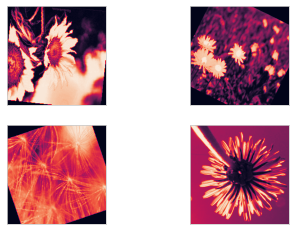

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(samples[i][0])
plt.show()

In [23]:
def imshow(img,title):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(title)
    plt.show()

In [24]:
sample = samples[:4]
label = labels[:4]
out = torchvision.utils.make_grid(sample)

In [25]:
class_name = train_data.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


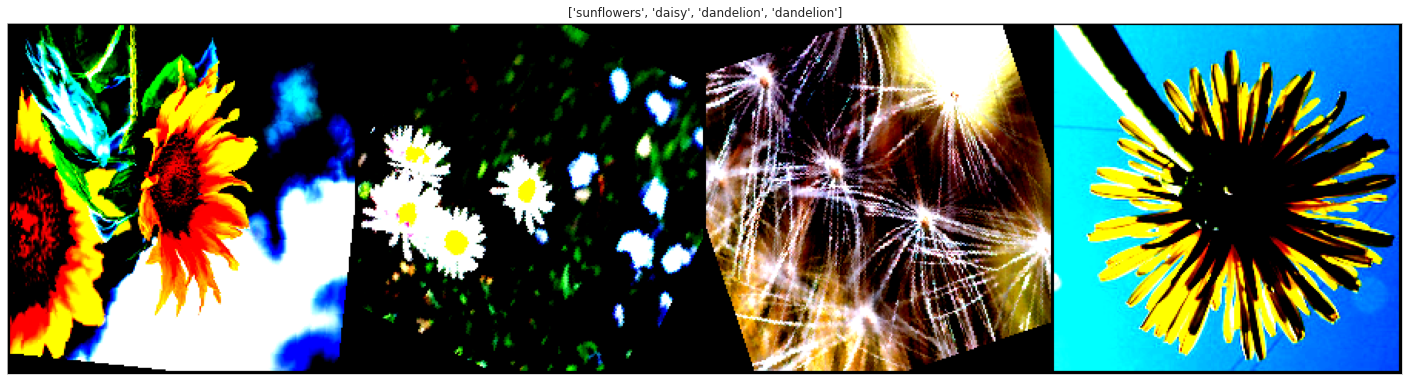

In [26]:
imshow(out,title=[class_name[x] for x in label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


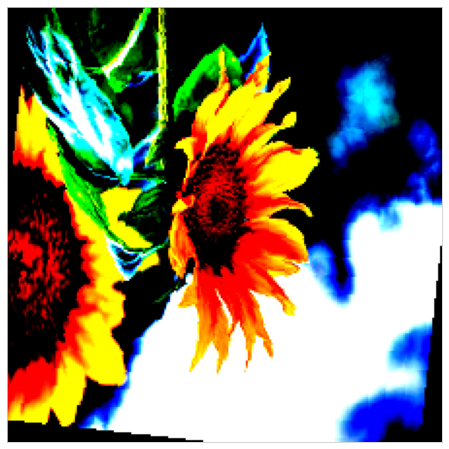

In [27]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.title(title)
    plt.show()
imshow(samples[0])

In [28]:
model = models.resnet18(pretrained=True)
model = model.to(DEVICE)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(DEVICE)

In [30]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        if (batch_idx) % 64 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (valid_loader):
            data_t, target_t = data_t.to(DEVICE), target_t.to(DEVICE)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(valid_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    model.train()

Epoch 1



/home/aarav/anaconda3/envs/pract/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/5], Step [0/184], Loss: 1.6085
Epoch [1/5], Step [64/184], Loss: 1.8949
Epoch [1/5], Step [128/184], Loss: 1.6053

train-loss: 1.5629, train-acc: 35.3202
validation loss: 1.3274, validation acc: 52.0436

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/184], Loss: 1.0276
Epoch [2/5], Step [64/184], Loss: 1.0312
Epoch [2/5], Step [128/184], Loss: 1.0744

train-loss: 1.3507, train-acc: 62.9768
validation loss: 1.1337, validation acc: 69.7548

Improvement-Detected, save-model
Epoch 3

Epoch [3/5], Step [0/184], Loss: 1.2915
Epoch [3/5], Step [64/184], Loss: 1.0108
Epoch [3/5], Step [128/184], Loss: 0.7695

train-loss: 1.1932, train-acc: 74.2166
validation loss: 0.9986, validation acc: 77.9292

Improvement-Detected, save-model
Epoch 4

Epoch [4/5], Step [0/184], Loss: 0.7799
Epoch [4/5], Step [64/184], Loss: 0.9163
Epoch [4/5], Step [128/184], Loss: 0.7332

train-loss: 1.0767, train-acc: 79.3256
validation loss: 0.9007, validation acc: 81.3351

Improvement-Detected, 

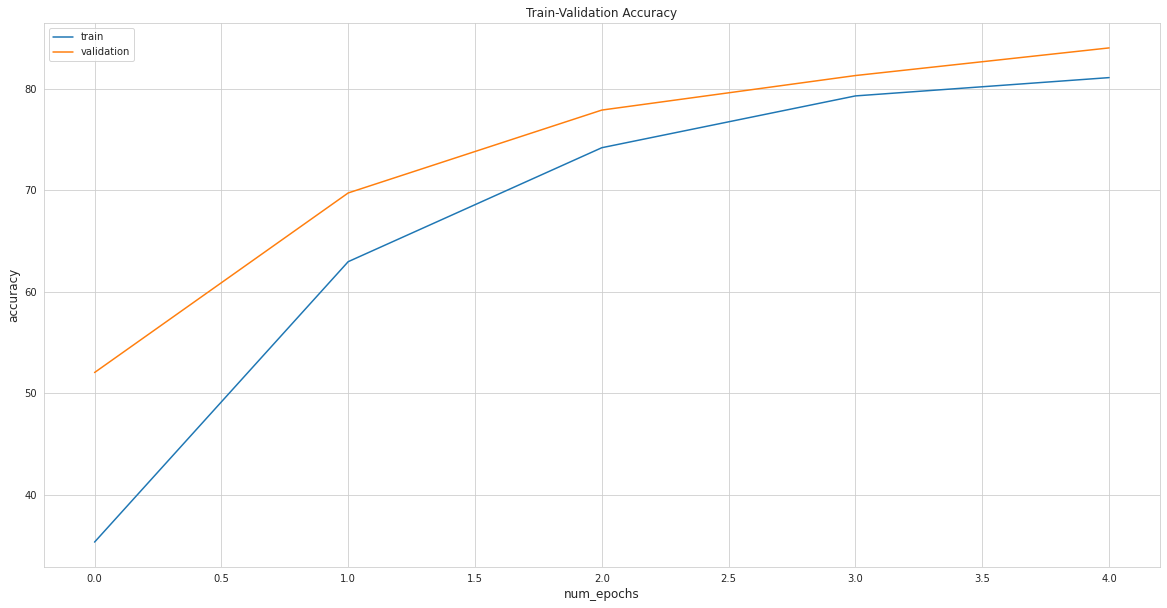

In [31]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


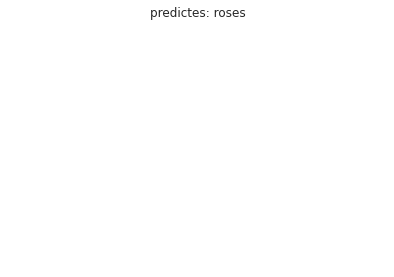

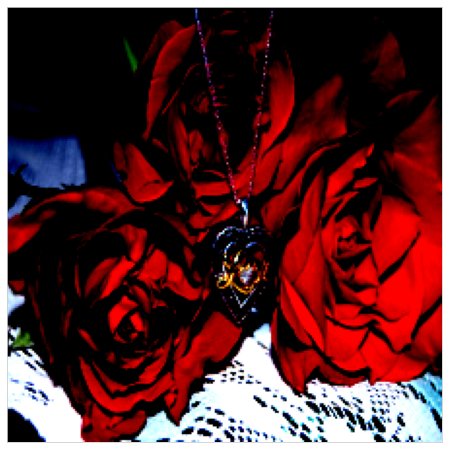

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


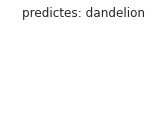

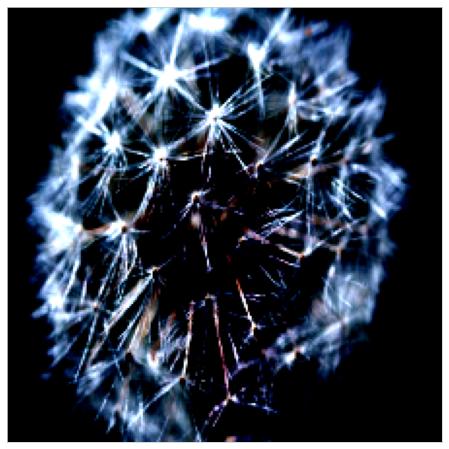

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


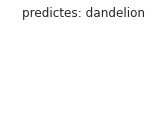

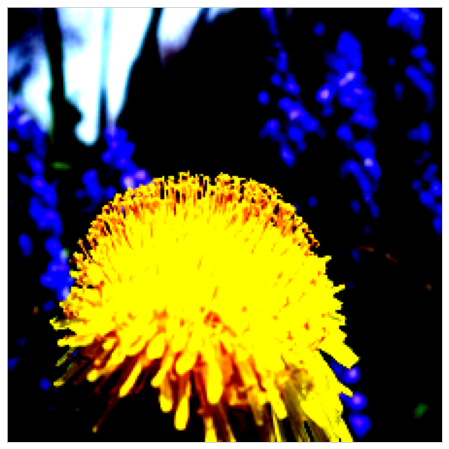

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


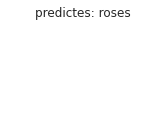

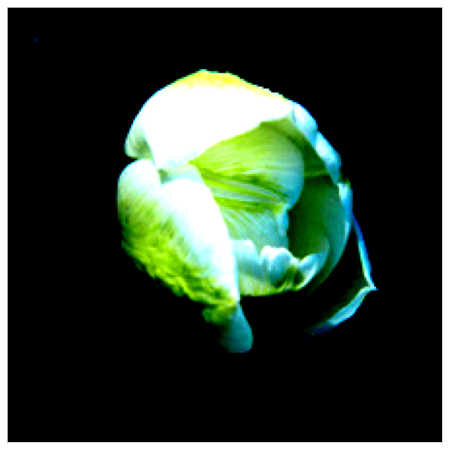

In [35]:
def visualize_model(model, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(valid_loader):
        inputs, labels = data
        #if use_cuda:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.to(DEVICE)
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(valid_data.classes[preds[j]]))
            imshow(inputs[j].cpu())
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(model)
plt.ioff()